# Korean Tokenizer Training with huggingface tokenizer

220831

- huggingface의 tokenizers를 이용해서 한글 tokenizer를 학습


### 주의!!
- BertWordPieceTokenizer 학습 시 한국어는 strip_accents를 False로 해줘야 한다
- 만약 True일 시 나는 -> 'ㄴ','ㅏ','ㄴ','ㅡ','ㄴ' 로 쪼개져서 처리된다
- 학습시 False했으므로 load할 때도 False를 꼭 확인해야 한다

### Reference
- [keep steady](https://keep-steady.tistory.com/37?category=702926)
- [transformers](https://github.com/huggingface/transformers/blob/master/notebooks/02-transformers.ipynb)

# 0. 설치(220831 최신버전)

In [1]:
# setup
!pip install transformers==4.21.2
!pip install tokenizers==0.12.1

!python -m pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.6 MB/s 
     |████████████████████████████████| 120 kB 65.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 62.7 MB/s 


# 1. 형태소 분석 적용

[('굳 ㅋ', 1), ('GDNTOPCLASSINTHECLUB', 0)]
data loading done!
sentence: ['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아']
Label   : [1, 0, 0]

코퍼스 문장수/평균/총 단어 갯수 : 49997, 7.6 / 380472


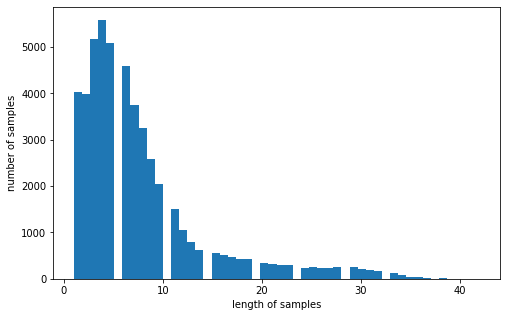

In [2]:
## 1.2) read csv data
# NSMC 데이터 로드
import pandas as pd
# data_nsmc = pd.read_csv('data/nsmc.txt', sep='\t')
data_nsmc = pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_pair = [(row[1], row[2]) for _, row in data_nsmc.iterrows() if type(row[1]) == str]  # nan 제거
print(train_pair[:2])

#  문장 및 라벨 데이터 추출
train_data  = [pair[0] for pair in train_pair]
train_label = [pair[1] for pair in train_pair]
print('data loading done!')
print('sentence: %s' %(train_data[:3]))
print('Label   : %s' %(train_label[:3]))

num_word_list = [len(sentence.split()) for sentence in train_data]
print('\n코퍼스 문장수/평균/총 단어 갯수 : %d, %.1f / %d' % (len(num_word_list), sum(num_word_list)/len(num_word_list), sum(num_word_list)))

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(num_word_list, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

data = train_data

In [3]:
%%time
from konlpy.tag import Okt
from tqdm import tqdm
okt = Okt()
print('okt check :', okt.morphs('어릴때보고 지금다시봐도 재밌어요ㅋㅋ'))
# ['어릴', '때', '보고', '지금', '다시', '봐도', '재밌어요', 'ㅋㅋ']

total_morph=[]
for sentence in tqdm(data):
    # 문장단위 mecab 적용
    morph_sentence= okt.morphs(sentence)
    # 문장단위 저장
    total_morph.append(morph_sentence)
                        
print(total_morph[:3])
print(len(total_morph))

# mecab 적용한 데이터 저장
# ex) 1 line: '어릴 때 보 고 지금 다시 봐도 재밌 어요 ㅋㅋ'
with open('after_morph.txt', 'w', encoding='utf-8') as f:
    for line in total_morph:
        f.write(' '.join(line)+'\n')

okt check : ['어릴', '때', '보고', '지금', '다시', '봐도', '재밌어요', 'ㅋㅋ']


100%|██████████| 49997/49997 [02:01<00:00, 410.71it/s]

[['굳', 'ㅋ'], ['GDNTOPCLASSINTHECLUB'], ['뭐', '야', '이', '평점', '들', '은', '....', '나쁘진', '않지만', '10', '점', '짜', '리', '는', '더', '더욱', '아니잖아']]
49997
CPU times: user 2min 10s, sys: 1.41 s, total: 2min 11s
Wall time: 2min 9s


# Train Tokenizer

downstream task를 위해 UNK와 많은 unused가 필요하다.

1) define special tokens

2) train

In [4]:
## 1) define special tokens
user_defined_symbols = ['[BOS]','[EOS]','[UNK0]','[UNK1]','[UNK2]','[UNK3]','[UNK4]','[UNK5]','[UNK6]','[UNK7]','[UNK8]','[UNK9]']
unused_token_num = 20
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
user_defined_symbols = user_defined_symbols + unused_list

print(user_defined_symbols)

['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]']


In [5]:
%%time
## 2) train
import os
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer, CharBPETokenizer, ByteLevelBPETokenizer

# 4가지중 tokenizer 선택
how_to_tokenize = BertWordPieceTokenizer  # The famous Bert tokenizer, using WordPiece
# how_to_tokenize = SentencePieceBPETokenizer  # A BPE implementation compatible with the one used by SentencePiece
# how_to_tokenize = CharBPETokenizer  # The original BPE
# how_to_tokenize = ByteLevelBPETokenizer  # The byte level version of the BPE

# Initialize a tokenizer
if str(how_to_tokenize) == str(BertWordPieceTokenizer):
    print('BertWordPieceTokenizer')
    ## 주의!! 한국어는 strip_accents를 False로 해줘야 한다
    # 만약 True일 시 나는 -> 'ㄴ','ㅏ','ㄴ','ㅡ','ㄴ' 로 쪼개져서 처리된다
    # 학습시 False했으므로 load할 때도 False를 꼭 확인해야 한다
    tokenizer = BertWordPieceTokenizer(strip_accents=False,  # Must be False if cased model
                                       lowercase=False)
elif str(how_to_tokenize) == str(SentencePieceBPETokenizer):
    print('SentencePieceBPETokenizer')
    tokenizer = SentencePieceBPETokenizer()

elif str(how_to_tokenize) == str(CharBPETokenizer):
    print('CharBPETokenizer')
    tokenizer = CharBPETokenizer()
    
elif str(how_to_tokenize) == str(ByteLevelBPETokenizer):
    print('ByteLevelBPETokenizer')
    tokenizer = ByteLevelBPETokenizer()
       
else:
    assert('select right tokenizer')

#########################################
corpus_file   = ['after_morph.txt']  # data path
vocab_size    = 32000
limit_alphabet= 6000
output_path   = 'hugging_%d'%(vocab_size)
min_frequency = 5

# Then train it!
tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,  # 단어의 최소 발생 빈도, 5
               limit_alphabet=limit_alphabet,  # ByteLevelBPETokenizer 학습시엔 주석처리 필요
               show_progress=True)
print('train complete')

sentence = '나는 오늘 아침밥을 먹었다.'
output = tokenizer.encode(sentence)
print(sentence)
print('=>tokens: %s'%output.tokens)
print('=>idx   : %s'%output.ids)
print('=>offset: %s'%output.offsets)
print('=>decode: %s\n'%tokenizer.decode(output.ids))

sentence = 'I want to go my hometown'
output = tokenizer.encode(sentence)
print(sentence)
print('=>tokens: %s'%output.tokens)
print('=>idx   : %s'%output.ids)
print('=>offset: %s'%output.offsets)
print('=>decode: %s\n'%tokenizer.decode(output.ids))

# save tokenizer
hf_model_path='tokenizer_model'
if not os.path.isdir(hf_model_path):
    os.mkdir(hf_model_path)
tokenizer.save_model(hf_model_path)  # vocab.txt 파일 한개가 만들어진다

BertWordPieceTokenizer
train complete
나는 오늘 아침밥을 먹었다.
=>tokens: ['나는', '오늘', '아침', '##밥', '##을', '먹었다', '.']
=>idx   : [15922, 4533, 5522, 3013, 2360, 10272, 18]
=>offset: [(0, 2), (3, 5), (6, 8), (8, 9), (9, 10), (11, 14), (14, 15)]
=>decode: 나는 오늘 아침밥을 먹었다.

I want to go my hometown
=>tokens: ['I', 'w', '##ant', 'to', 'go', 'my', 'h', '##om', '##et', '##ow', '##n']
=>idx   : [45, 91, 17314, 7450, 14414, 10654, 76, 7518, 12954, 8045, 2449]
=>offset: [(0, 1), (2, 3), (3, 6), (7, 9), (10, 12), (13, 15), (16, 17), (17, 19), (19, 21), (21, 23), (23, 24)]
=>decode: I want to go my hometown

CPU times: user 2.4 s, sys: 340 ms, total: 2.74 s
Wall time: 1.63 s


['tokenizer_model/vocab.txt']

# Check import tokenizer from Transformers

BertTokenizerFast 는 학습한 환경과 똑같이 strip_accents=False 로 줘야한다

True로 주면 '나는'->'ㄴㅏㄴㅡㄴ' 과 같이 쪼개져서 인식해서 안된다

In [6]:
from transformers import BertTokenizerFast

tokenizer_for_load = BertTokenizerFast.from_pretrained(hf_model_path,
                                                       strip_accents=False,  # Must be False if cased model
                                                       lowercase=False)  # 로드

print('vocab size : %d' % tokenizer_for_load.vocab_size)
# tokenized_input_for_pytorch = tokenizer_for_load("i am very hungry", return_tensors="pt")
tokenized_input_for_pytorch = tokenizer_for_load("나는 오늘 아침밥을 먹었다.", return_tensors="pt")
tokenized_input_for_tensorflow = tokenizer_for_load("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

print("Tokens (str)      : {}".format([tokenizer_for_load.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

vocab size : 17684
Tokens (str)      : ['[CLS]', '나는', '오늘', '아침', '##밥', '##을', '먹었다', '.', '[SEP]']
Tokens (int)      : [2, 15922, 4533, 5522, 3013, 2360, 10272, 18, 3]
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1]



In [7]:
# vocab check
tokenizer_for_load.get_vocab()

{'미야': 8535,
 '남았다': 10237,
 '막': 984,
 '통일': 10420,
 '답답해서': 11065,
 '할수있': 6174,
 '##고': 2363,
 '##팟': 3823,
 '##뚱': 3246,
 '체험': 9068,
 '때론': 9574,
 '니콜슨': 15531,
 '놔서': 15970,
 '##B': 2451,
 '##0분': 4739,
 '무죄': 13520,
 '##덩': 3755,
 '톡': 2096,
 '그러나': 4939,
 '지극히': 7945,
 '##붐': 3019,
 '어벤': 9311,
 '구경': 9540,
 '죄다': 5864,
 '다시': 4119,
 '하비': 16731,
 '사람과': 7532,
 '반대': 6810,
 '##래도': 8053,
 '##럽다': 5657,
 '싸': 1398,
 '사기': 5502,
 '꺼리': 14491,
 '진의': 10007,
 '영화관': 4546,
 '재밌는': 4606,
 '쁠': 1248,
 '야하다': 12716,
 '청자': 16641,
 '찌질한': 10165,
 'BEST': 17594,
 '##트': 2510,
 '캴': 1987,
 '고도': 10218,
 '묻혀': 11904,
 '지나면': 15413,
 '##휴': 3367,
 '만난': 8526,
 '아닌': 4174,
 '놀라웠다': 17253,
 '##5년': 5178,
 '월드': 7605,
 '##컵': 4037,
 '느껴지는': 5334,
 '스타뎀': 11607,
 '열정': 6299,
 '남아': 5117,
 '##었어': 6700,
 '박근': 14681,
 '익숙': 6631,
 '아쉬웠음': 14099,
 '리기': 8522,
 '흐지': 9377,
 '됐어': 14581,
 '##뇨': 3499,
 '웃기긴': 11600,
 '##캬': 3842,
 '역대': 4993,
 '##수있': 5682,
 '좋았습니다': 5196,
 '튀김': 16696,
 '비틀': 1077

In [8]:
# special token check
tokenizer_for_load.all_special_tokens # 추가하기 전 기본적인 special token

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [9]:
# tokenizer에 special token 추가
special_tokens_dict = {'additional_special_tokens': user_defined_symbols}
tokenizer_for_load.add_special_tokens(special_tokens_dict)

# check tokenizer vocab with special tokens
print('check special tokens : %s'%tokenizer_for_load.all_special_tokens[:20])

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']


In [10]:
# save tokenizer model with special tokens
tokenizer_for_load.save_pretrained(hf_model_path+'_special')

('tokenizer_model_special/tokenizer_config.json',
 'tokenizer_model_special/special_tokens_map.json',
 'tokenizer_model_special/vocab.txt',
 'tokenizer_model_special/added_tokens.json',
 'tokenizer_model_special/tokenizer.json')

In [11]:
# check special tokens
from transformers import BertTokenizerFast
tokenizer_check = BertTokenizerFast.from_pretrained(hf_model_path+'_special')

print('check special tokens : %s'%tokenizer_check.all_special_tokens[:20])

print('vocab size : %d' % tokenizer_check.vocab_size)
tokenized_input_for_pytorch = tokenizer_check("나는 오늘 아침밥을 먹었다.", return_tensors="pt")
tokenized_input_for_tensorflow = tokenizer_check("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

print("Tokens (str)      : {}".format([tokenizer_check.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']
vocab size : 17684
Tokens (str)      : ['[CLS]', '나는', '오늘', '아침', '##밥', '##을', '먹었다', '.', '[SEP]']
Tokens (int)      : [2, 15922, 4533, 5522, 3013, 2360, 10272, 18, 3]
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1]



In [12]:
# test to tf&pytorch bert model
from transformers import TFBertModel, BertModel

# load a BERT model for TensorFlow and PyTorch
model_tf = TFBertModel.from_pretrained('bert-base-cased')
model_pt = BertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
## tf vs torch bert output
# transformers generates a ready to use dictionary with all the required parameters for the specific framework.
input_tf = tokenizer_check("나는 오늘 아침밥을 먹었다.", return_tensors="tf")
input_pt = tokenizer_check("나는 오늘 아침밥을 먹었다.", return_tensors="pt")

# Let's compare the outputs
output_tf, output_pt = model_tf(input_tf), model_pt(**input_pt)

print('final layer output shape : %s'%(output_pt['last_hidden_state'].shape,))

# Models outputs 2 values (The value for each tokens, the pooled representation of the input sentence)
# Here we compare the output differences between PyTorch and TensorFlow.

print('\ntorch vs tf 결과차이')
for name in ["last_hidden_state", "pooler_output"]:
    print("   => {} differences: {:.5}".format(name, (output_tf[name].numpy() - output_pt[name].detach().numpy()).sum()))

final layer output shape : torch.Size([1, 9, 768])

torch vs tf 결과차이
   => last_hidden_state differences: 8.1448e-05
   => pooler_output differences: 0.00030048
